In [30]:
import numpy as np
import scipy.stats
import json
import random
import prior_envs, diffplan, envs, search, spectral

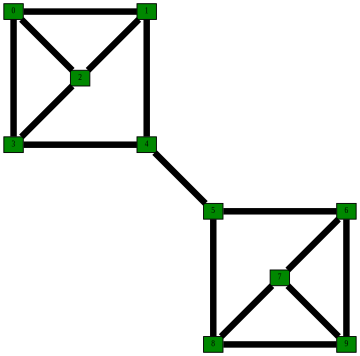

In [31]:
env = prior_envs.f2c
diffplan.plot_graph(env, size=5, labels=list(map(str, range(len(env.states)))))

In [32]:
tasks = [
    dict(start=s, goal=g, optimal=search.bfs(env, s, g)['cost'])
    for s in env.states
    for g in env.states
    if s != g
]
import collections
print('counts for path lengths', sorted(collections.Counter(t['optimal'] for t in tasks).items()))
print(len(tasks))

# Filter out length-1 tasks
tasks = [t for t in tasks if t['optimal'] != 1]
print(len(tasks))

counts for path lengths [(1, 30), (2, 20), (3, 16), (4, 16), (5, 8)]
90
60


# Testing new node assignment scheme

In [33]:
def new_assign(env, *, prohibit_succ_dist=2):
    num_states = len(env.states)
    assert env.states == range(num_states) # We assume states are just the numbers...
    order = [None] * num_states
    for si in range(num_states):
        # figure out valid places
        succ = {env.step(si, a)[0] for a in env.actions}
        valid = [
            idx
            for idx in range(num_states)
            # Needs to be unassigned
            if order[idx] is None
            # And needs successors to be distance `prohibit_succ_dist` at least.
            if all(
                (
                    order[(idx-dist) % num_states] not in succ and
                    order[(idx+dist) % num_states] not in succ
                )
                # We don't check for 0
                for dist in range(1, prohibit_succ_dist+1)
            )
        ]
        if not valid:
            return
        # randomly sample
        order[np.random.choice(valid)] = si
    return order

sum(
    1 
    for _ in range(100)
    if new_assign(prior_envs.f2c, prohibit_succ_dist=2) is not None
)

12

In [34]:
def repeat_not_none(fn, *, limit=100):
    for _ in range(limit):
        rv = fn()
        if rv is not None:
            return rv
np.random.seed(42)
order = repeat_not_none(lambda: new_assign(prior_envs.f2c))
print(order)

[9, 5, 2, 7, 4, 0, 8, 6, 3, 1]


# Enumerating accept/reject trials

In [35]:
acceptreject_all = [
    # (start, goal, accept [non-bottle, bottle], reject [non-bottle, bottle])
    (s, g, [[1,3,6,8], [4,5]], [{0,2,7,9}-{s,g}, []])
    for s_ in [0, 2] for g_ in [7, 9]
    for s, g in ((s_, g_), (g_, s_))
] + [
    # (start, goal, accept [non-bottle, bottle], reject [non-bottle, bottle])
    (s, g, [[1,3], []], [{0,2,6,7,8,9}-{s,g}, [5]])
    for s_ in [0, 2] for g_ in [4]
    for s, g in ((s_, g_), (g_, s_))
] + [
    # (start, goal, accept [non-bottle, bottle], reject [non-bottle, bottle])
    (s, g, [[6,8], []], [{0,1,2,3,7,9}-{s,g}, [4]])
    for s_ in [7, 9] for g_ in [5]
    for s, g in ((s_, g_), (g_, s_))
]

indexed_ar = {
    (aname, bname): [
        (s, g, probe)
        for s, g, a, r in acceptreject_all
        for probe in (a if accept else r)[1 if bottleneck else 0]
    ]
    for aname, accept in [('accept', True), ('reject', False)]
    for bname, bottleneck in [('bottleneck', True), ('not bottle', False)]
}
print(indexed_ar.keys())
for k, v in indexed_ar.items():
    print(k)
    for it in v:
        print('\t', it)

dict_keys([('accept', 'bottleneck'), ('accept', 'not bottle'), ('reject', 'bottleneck'), ('reject', 'not bottle')])
('accept', 'bottleneck')
	 (0, 7, 4)
	 (0, 7, 5)
	 (7, 0, 4)
	 (7, 0, 5)
	 (0, 9, 4)
	 (0, 9, 5)
	 (9, 0, 4)
	 (9, 0, 5)
	 (2, 7, 4)
	 (2, 7, 5)
	 (7, 2, 4)
	 (7, 2, 5)
	 (2, 9, 4)
	 (2, 9, 5)
	 (9, 2, 4)
	 (9, 2, 5)
('accept', 'not bottle')
	 (0, 7, 1)
	 (0, 7, 3)
	 (0, 7, 6)
	 (0, 7, 8)
	 (7, 0, 1)
	 (7, 0, 3)
	 (7, 0, 6)
	 (7, 0, 8)
	 (0, 9, 1)
	 (0, 9, 3)
	 (0, 9, 6)
	 (0, 9, 8)
	 (9, 0, 1)
	 (9, 0, 3)
	 (9, 0, 6)
	 (9, 0, 8)
	 (2, 7, 1)
	 (2, 7, 3)
	 (2, 7, 6)
	 (2, 7, 8)
	 (7, 2, 1)
	 (7, 2, 3)
	 (7, 2, 6)
	 (7, 2, 8)
	 (2, 9, 1)
	 (2, 9, 3)
	 (2, 9, 6)
	 (2, 9, 8)
	 (9, 2, 1)
	 (9, 2, 3)
	 (9, 2, 6)
	 (9, 2, 8)
	 (0, 4, 1)
	 (0, 4, 3)
	 (4, 0, 1)
	 (4, 0, 3)
	 (2, 4, 1)
	 (2, 4, 3)
	 (4, 2, 1)
	 (4, 2, 3)
	 (7, 5, 6)
	 (7, 5, 8)
	 (5, 7, 6)
	 (5, 7, 8)
	 (9, 5, 6)
	 (9, 5, 8)
	 (5, 9, 6)
	 (5, 9, 8)
('reject', 'bottleneck')
	 (0, 4, 5)
	 (4, 0, 5)
	 (2, 4, 5)
	 (4,

# Generating experiment

In [39]:
# Write out graph
graph = [
    [s, [env.step(s, a)[0].item() for a in env.actions]]
    for s in env.states
]

# Write out state orders
np.random.seed(27430)
state_orders = [so.tolist() for so in [
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
]]
for so in state_orders:
    print
state_orders.pop(4) # This is a kinda bad ordering. May be worth keeping...
state_orders.pop(3) # This is a bad ordering.
state_orders.pop(1) # This is a bad ordering.
print(state_orders)
'''
state_orders = [
    repeat_not_none(lambda: new_assign(env)),
    repeat_not_none(lambda: new_assign(env)),
    repeat_not_none(lambda: new_assign(env)),
    repeat_not_none(lambda: new_assign(env)),
]
print(state_orders)
'''

# Write out task orders
random.seed(27432)
def shuffled(l):
    l = list(l) # we make a copy here...
    random.shuffle(l) # because this is in-place!
    return l
task_orders = []
for _ in range(4):
    task_orders.append(shuffled(tasks))

# Write out probes
random.seed(27444)
def pairs(to, fro):
    for t in to:
        for f in fro:
            yield (t, f)
probes = shuffled([
    dict(start=s, goal=g)
    for s, g in (
        list(pairs([0, 2], [4, 7, 9])) +
        list(pairs([7, 9], [0, 2, 5])) +
        list(pairs([5], [7, 9])) +
        list(pairs([4], [0, 2]))
    )
])
print('probes', len(probes), probes)

probes_alternate = shuffled(probes)
print('probes_alternate', probes_alternate)

random.seed(11230)
acceptreject = shuffled([
    dict(start=start, goal=goal, probe=probe, trial_type=key)
    for key, trials in indexed_ar.items()
    for start, goal, probe in shuffled(trials)[:4]
])
print('\nacceptreject', acceptreject)

[[1, 0, 6, 4, 3, 7, 8, 2, 9, 5], [7, 8, 6, 0, 5, 2, 9, 4, 3, 1], [2, 5, 3, 9, 4, 6, 0, 8, 1, 7]]
probes 16 [{'start': 7, 'goal': 5}, {'start': 0, 'goal': 4}, {'start': 9, 'goal': 2}, {'start': 7, 'goal': 0}, {'start': 5, 'goal': 9}, {'start': 4, 'goal': 0}, {'start': 2, 'goal': 4}, {'start': 7, 'goal': 2}, {'start': 2, 'goal': 7}, {'start': 0, 'goal': 7}, {'start': 9, 'goal': 0}, {'start': 2, 'goal': 9}, {'start': 5, 'goal': 7}, {'start': 4, 'goal': 2}, {'start': 9, 'goal': 5}, {'start': 0, 'goal': 9}]
probes_alternate [{'start': 4, 'goal': 0}, {'start': 7, 'goal': 0}, {'start': 0, 'goal': 7}, {'start': 9, 'goal': 5}, {'start': 4, 'goal': 2}, {'start': 7, 'goal': 5}, {'start': 2, 'goal': 9}, {'start': 0, 'goal': 9}, {'start': 0, 'goal': 4}, {'start': 9, 'goal': 0}, {'start': 9, 'goal': 2}, {'start': 5, 'goal': 7}, {'start': 7, 'goal': 2}, {'start': 5, 'goal': 9}, {'start': 2, 'goal': 7}, {'start': 2, 'goal': 4}]

acceptreject [{'start': 2, 'goal': 9, 'probe': 5, 'trial_type': ('accept'

In [40]:
def write_json_module(fn, data):
    with open(fn, 'w') as f:
        f.write('export default ')
        #json.dump(data, f, indent=2)
        json.dump(data, f)
        f.write(';')

write_json_module('experiment/trials.js', dict(
    graph=graph,
    stateOrders=state_orders,
    taskOrders=task_orders,
    probes=probes,
    probesAlternate=probes_alternate,
    acceptreject=acceptreject,
))


In [41]:
!mkdir -p ~/pu/cocosci-optdisco/static/optdisco/js/configuration/
!ls -lah experiment/*.js
!cp experiment/*.js ~/pu/cocosci-optdisco/static/optdisco/js/configuration/

-rw-r--r--  1 carlos  staff    11K Jun 15 17:01 experiment/trials.js


# Analyzing stimuli
Some graph orderings seem especially easy, or like they have strong clustering. Comparing two metrics below: number of edges that are along the perimeter (or: how many neighbors on the circle are true neighbors in the graph) and spearman rank correlation to the best 1-dimensional embedding.

In [122]:
# making sure tasks are well-distributed among difficulties

limit = 30

random.seed(27432)
for _ in range(8):
    t = shuffled(tasks)
    print(collections.Counter(task['optimal'] for task in t[:limit]))


Counter({4: 12, 3: 6, 2: 6, 5: 6})
Counter({2: 11, 4: 8, 3: 7, 5: 4})
Counter({2: 11, 4: 8, 3: 7, 5: 4})
Counter({2: 9, 4: 8, 3: 7, 5: 6})
Counter({2: 10, 3: 9, 4: 8, 5: 3})
Counter({3: 11, 2: 9, 4: 8, 5: 2})
Counter({2: 14, 4: 8, 3: 6, 5: 2})
Counter({2: 12, 4: 8, 3: 7, 5: 3})


In [123]:
fiedler_order = spectral.fiedler(env).argsort()

np.random.seed(27430)
state_orders = [so.tolist() for so in [
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
]]
'''
state_orders = [
    repeat_not_none(lambda: new_assign(env)),
    repeat_not_none(lambda: new_assign(env)),
    repeat_not_none(lambda: new_assign(env)),
    repeat_not_none(lambda: new_assign(env)),
]
'''

def edges_on_side(so, max_distance_penalty=2):
    total = 0
    for idx, s in enumerate(so):
        circle_neighbors = lambda dist: {
            so[(idx - dist) % len(so)],
            so[(idx + dist) % len(so)],
        }
        neighbors = {env.step(s, a)[0].item() for a in env.actions}
        p = 1/2
        total += sum(
            p**dist * len(circle_neighbors(dist+1) & neighbors)
            for dist in range(max_distance_penalty)
        ) ** 2
    return total/2 # remove symmetry

for so in state_orders:
    print(so)
    so_rots = [so[idx:] + so[:idx] for idx in range(len(so))]
    so_rot = max(so_rots, key=lambda so_rot: abs(scipy.stats.spearmanr(so_rot, fiedler_order).correlation))
    print(scipy.stats.spearmanr(so_rot, fiedler_order))
    print('# edges on side (d=1)', edges_on_side(so, max_distance_penalty=1))
    print('# edges on side (d=2)', edges_on_side(so, max_distance_penalty=2))
    print('# edges on side (d=3)', edges_on_side(so, max_distance_penalty=3))
    print()

[1, 0, 6, 4, 3, 7, 8, 2, 9, 5]
SpearmanrResult(correlation=-0.7939393939393938, pvalue=0.0060999233136969115)
# edges on side (d=1) 3.0
# edges on side (d=2) 3.75
# edges on side (d=3) 7.125

[8, 7, 5, 6, 2, 0, 1, 9, 3, 4]
SpearmanrResult(correlation=-0.5393939393939393, pvalue=0.1075931877824148)
# edges on side (d=1) 6.0
# edges on side (d=2) 9.75
# edges on side (d=3) 12.4375

[7, 8, 6, 0, 5, 2, 9, 4, 3, 1]
SpearmanrResult(correlation=0.3939393939393939, pvalue=0.25999776683488757)
# edges on side (d=1) 2.0
# edges on side (d=2) 4.25
# edges on side (d=3) 5.75

[1, 9, 4, 8, 7, 5, 6, 0, 3, 2]
SpearmanrResult(correlation=-0.6848484848484848, pvalue=0.02888279750673276)
# edges on side (d=1) 7.0
# edges on side (d=2) 13.0
# edges on side (d=3) 14.9375

[3, 6, 2, 9, 8, 0, 5, 4, 7, 1]
SpearmanrResult(correlation=-0.5151515151515151, pvalue=0.12755286970323426)
# edges on side (d=1) 2.0
# edges on side (d=2) 5.0
# edges on side (d=3) 6.3125

[2, 5, 3, 9, 4, 6, 0, 8, 1, 7]
SpearmanrResult(

[1, 0, 6, 4, 3, 7, 8, 2, 9, 5]


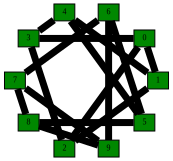

[8, 7, 5, 6, 2, 0, 1, 9, 3, 4]


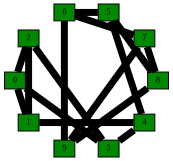

[7, 8, 6, 0, 5, 2, 9, 4, 3, 1]


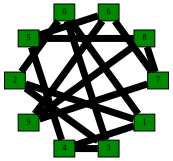

[1, 9, 4, 8, 7, 5, 6, 0, 3, 2]


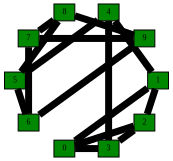

[3, 6, 2, 9, 8, 0, 5, 4, 7, 1]


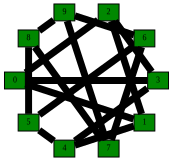

[2, 5, 3, 9, 4, 6, 0, 8, 1, 7]


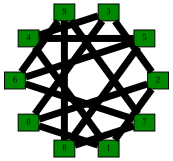

In [124]:
def render_ordering(env, order):
    oldpos = env.pos
    import math
    env.pos = [
        (
            math.cos(2*math.pi/len(env.states)*order.index(s)),
            math.sin(2*math.pi/len(env.states)*order.index(s)),
        )
        for s in env.states
    ]
    g = diffplan.plot_graph(env, labels=list(map(str,env.states)))
    env.pos = oldpos
    return g

from IPython.display import display
env = prior_envs.f2c
for so in state_orders:
    #so = repeat_not_none(lambda: new_assign(env, prohibit_succ_dist=1))
    print(so)
    display(render_ordering(env, so))